In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import norm, uniform

# Rejection Sampling

Rejection sampling allows to draw samples from a desired distribution $f$ via drawing from a rather similar distribution $g$ and rejecting samples of $g$ with a certain probability if they do not fit the desired frequency coming with the desired probability distribution. The efficiency of the rejection sampling method highly depends on the choice of the precursor distribution $g$ (which needs to have the same support as $f$).

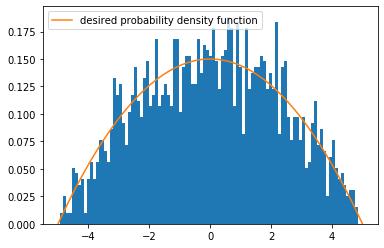

In [29]:
support = np.linspace(-5, 5)


def unnormalized_desired_prbability_function(support):
    offset = 25
    return -(support ** 2) + offset


def desired_probability_density_function(support):
    normalization = quad(unnormalized_desired_prbability_function, -5, 5)[0]
    return unnormalized_desired_prbability_function(support) / normalization


pdf = desired_probability_density_function(support)

g_dist = uniform
# g_dist = norm also works, needs g_dist.pdf(x, loc=0, scale=4) then
# factor for upscaling g such that k*g >= f
k = np.max(pdf) / g_dist.pdf(0, loc=-5, scale=10)

num_samples = 2000
samples = []

while len(samples) < num_samples:
    u = np.random.uniform(0, 1)
    x = g_dist.rvs(loc=-5, scale=10)  # g distributed
    if u * k * g_dist.pdf(x, loc=-5, scale=10) < desired_probability_density_function(
        x
    ):
        # accept the sample x ~ g, if u is by chance such that u*k*g(x) falls below desired_density f(x)
        # at x where desired_probability_density_function f is big, this condition is statisfied by more u values
        # therefore the samples x~g are more often accepted as samples representing f, when f(x) is big
        # vice versa less samples x ~g are accepted for representing f, when f(x) is low
        samples.append(x)

plt.hist(samples, bins=100, density=True)
plt.plot(
    support,
    desired_probability_density_function(support),
    label="desired probability density function",
)
plt.legend()

# Inversion Method

In [30]:
from scipy import optimize

support = np.linspace(-5, 5)


def unnormalized_desired_prbability_function(support):
    offset = 25
    return -(support ** 2) + offset


def desired_probability_density_function(support):
    normalization = quad(unnormalized_desired_prbability_function, -5, 5)[0]
    return unnormalized_desired_prbability_function(support) / normalization


delta_s = support[1] - support[0]
cumulative_distribution_function = interp1d(
    support, np.cumsum(desired_probability_density_function(support) * delta_s)
)


def inverse_cumulative_distribution_function(
    cumulative_distribution_function, function_value
):
    def diff_function(x):
        return (cumulative_distribution_function(x) - function_value) ** 2

    return optimize.newton(diff_function, 0.5)


def sample_from_desired_cumulative_distribution_function(
    support, desired_probability_density
):
    u = np.random.uniform(1e-4, 1 - 1e-4)
    return inverse_cumulative_distribution_function(cumulative_distribution_function, u)


samples = [
    sample_from_desired_cumulative_distribution_function(
        support, desired_probability_density_function
    )
    for i in range(2000)
]

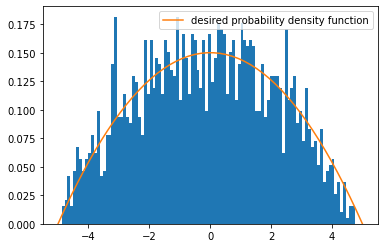

In [31]:
plt.hist(samples, density=True, bins=100)
plt.plot(
    support,
    desired_probability_density_function(support),
    label="desired probability density function",
)
plt.legend();